# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
from pyspark.sql import functions as F
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType
from pyspark.sql.window import Window
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, lit, isnan, when, count, col
from pyspark.ml.feature import StandardScaler, VectorAssembler
from pyspark.ml.feature import StringIndexer
import datetime

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
sns.set_style("darkgrid")

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [2]:
spark = SparkSession \
    .builder \
    .appName('Sparkify') \
    .getOrCreate()

In [3]:
# Read in sparkify dataset

#EVENT_DATA = 's3n://udacity-dsnd/sparkify/sparkify_event_data.json'
EVENT_DATA = 'mini_sparkify_event_data.json'

df = spark.read.json(EVENT_DATA)
df.head(5)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9'),
 Row(artist='Adam Lambert', auth='Logged In', firstName='Colin', gender='M', itemInSession=51, lastName='Freeman', length=282.8273, level='paid', location='

In [4]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [5]:
# df.describe().toPandas()

,summary,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,count,228108,286500,278154,278154,286500,278154,228108,286500,278154,286500,286500,278154,286500,228108,286500,286500,278154,286500
1,mean,551.0852017937219,None,None,None,114.41421291448516,None,249.1171819778458,None,None,None,None,1.5353588340844272E12,1041.526554973822,Infinity,210.05459685863875,1.5409568898104834E12,None,59682.02278593872
2,stddev,1217.7693079161374,None,None,None,129.76726201140994,None,99.23517921058361,None,None,None,None,3.291321616327586E9,726.7762634630741,NaN,31.50507848842214,1.5075439608226302E9,None,109091.9499991047
3,min,!!!,Cancelled,Adelaida,F,0,Adams,0.78322,free,"Albany, OR",GET,About,1521380675000,1,ÃÂg ÃÂtti GrÃÂ¡a ÃÂsku,200,1538352117000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10)...",
4,max,ÃÂlafur Arnalds,Logged Out,Zyonna,M,1321,Wright,3024.66567,paid,"Winston-Salem, NC",PUT,Upgrade,1543247354000,2474,ÃÂau hafa sloppiÃÂ° undan ÃÂ¾unga myrkursins,404,1543799476000,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,99


# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [6]:
df.filter((df["userId"] == "") | df["userId"].isNull() | isnan(df["userId"])).count()

8346

In [7]:
df.select([count(when(df[c].isNull(), c)).alias(c) for c in df.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
| 58392|   0|     8346|  8346|            0|    8346| 58392|    0|    8346|     0|   0|        8346|        0|58392|     0|  0|     8346|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+



In [8]:
df.select([count(when(isnan(df[c]), c)).alias(c) for c in df.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId|song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|     0|   0|        0|     0|            0|       0|     0|    0|       0|     0|   0|           0|        0|   0|     0|  0|        0|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+



In [9]:
df.select([count(when(df[c] == "", c)).alias(c) for c in df.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId|song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|     0|   0|        0|     0|            0|       0|     0|    0|       0|     0|   0|           0|        0|   0|     0|  0|        0|  8346|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+



In [10]:
df.createOrReplaceTempView('user_log')
clean_user_log = spark.sql('''
    SELECT *
    FROM user_log
    WHERE userId != ''
    '''
    )

clean_user_log.createOrReplaceTempView('clean_user_log')

In [11]:
clean_user_log.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')

In [12]:
spark.sql('''
    SELECT DISTINCT auth
    FROM clean_user_log
    '''
    ).show()

+---------+
|     auth|
+---------+
|Cancelled|
|Logged In|
+---------+



In [13]:
clean_user_log.groupby(['auth']).agg(F.expr('count(distinct userId)')).show()

+---------+-------------+
|     auth|count(userId)|
+---------+-------------+
|Cancelled|           52|
|Logged In|          225|
+---------+-------------+



In [14]:
clean_user_log.groupby(['gender']).agg(F.expr('count(distinct userId)')).show()

+------+-------------+
|gender|count(userId)|
+------+-------------+
|     F|          104|
|     M|          121|
+------+-------------+



In [15]:
clean_user_log.groupby(['page', 'level']).agg(F.expr('count(distinct userId)')).sort('count(userId)').show(50)

+--------------------+-----+-------------+
|                page|level|count(userId)|
+--------------------+-----+-------------+
|              Cancel| free|           21|
|Cancellation Conf...| free|           21|
|              Cancel| paid|           31|
|Cancellation Conf...| paid|           31|
|               Error| free|           41|
|    Submit Downgrade| paid|           49|
|       Save Settings| free|           59|
|               About| free|           63|
|               Error| paid|           95|
|       Save Settings| paid|           96|
|         Roll Advert| paid|           99|
|            Settings| free|          119|
|                Help| free|          125|
|               About| paid|          127|
|      Submit Upgrade| free|          131|
|         Thumbs Down| free|          135|
|            Settings| paid|          148|
|          Add Friend| free|          148|
|                Help| paid|          149|
|           Downgrade| paid|          154|
|          

In [16]:
clean_user_log.groupby(['level']).agg(F.expr('count(distinct userId)')).show()

+-----+-------------+
|level|count(userId)|
+-----+-------------+
| free|          195|
| paid|          165|
+-----+-------------+



In [17]:
clean_user_log.groupby(['status']).agg(F.expr('count(distinct userId)')).show()

+------+-------------+
|status|count(userId)|
+------+-------------+
|   307|          223|
|   404|          117|
|   200|          225|
+------+-------------+



In [18]:
clean_user_log.groupby(['userAgent']).agg(F.expr('count(distinct sessionId)')).sort(('count(sessionId)')).show(5, False)

+--------------------------------------------------------------------------------------------------------------------------+----------------+
|userAgent                                                                                                                 |count(sessionId)|
+--------------------------------------------------------------------------------------------------------------------------+----------------+
|"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_2) AppleWebKit/537.75.14 (KHTML, like Gecko) Version/7.0.3 Safari/537.75.14" |3               |
|"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_8_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"|4               |
|Mozilla/5.0 (X11; Ubuntu; Linux i686; rv:31.0) Gecko/20100101 Firefox/31.0                                                |4               |
|"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_6_8) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"|4               |
|"Mozi

In [19]:
print((df.count(), len(df.columns)))

(286500, 18)


In [20]:
get_time = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d %H:%M:%S"))

#Apply the udf on the ts column
clean_user_log = clean_user_log.withColumn("time", get_time(clean_user_log.ts))

In [21]:
clean_user_log = clean_user_log.withColumn("registration_date", get_time(clean_user_log["registration"]))

In [22]:
clean_user_log.describe()

DataFrame[summary: string, artist: string, auth: string, firstName: string, gender: string, itemInSession: string, lastName: string, length: string, level: string, location: string, method: string, page: string, registration: string, sessionId: string, song: string, status: string, ts: string, userAgent: string, userId: string, time: string, registration_date: string]

In [23]:
max_time_stamp = clean_user_log.agg(F.max(col("time")))

In [24]:
max_time_stamp = max_time_stamp.collect()[0][0]

In [25]:
max_time_stamp

'2018-12-03 01:11:16'

In [26]:
clean_user_log.createOrReplaceTempView("user_log_table")

In [27]:
how_long_a_user = spark.sql('''SELECT userId,
                                      datediff('2018-12-01 00:01:06' , registration_date) as how_long_a_user
                               FROM(SELECT userId,
                                           MIN(registration_date) as registration_date
                                    FROM user_log_table
                                    GROUP BY 1)
                            ''')

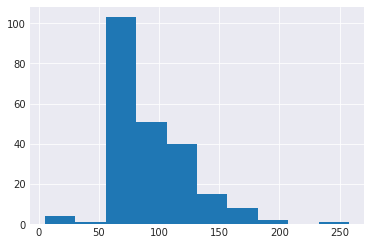

In [28]:
plt.hist(how_long_a_user.toPandas()['how_long_a_user']);

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [29]:
free_or_paid = udf(lambda x : 1 if x == 'paid' else 0, IntegerType())
was_paid = udf(lambda x : 1 if x > 0 else 0, IntegerType())

In [30]:
paid_users = clean_user_log.select('userID', 'level') \
                     .withColumn('free_or_paid', free_or_paid(col('level'))) \
                     .groupby('userID').agg(F.sum('free_or_paid')) \
                     .withColumn('was_paid_user', was_paid(col('sum(free_or_paid)'))).select(['userID','was_paid_user'])

In [31]:
paid_users.show(5)

+------+-------------+
|userID|was_paid_user|
+------+-------------+
|100010|            0|
|200002|            1|
|   125|            0|
|    51|            1|
|   124|            1|
+------+-------------+
only showing top 5 rows



#### Change Gender to Dummy

In [32]:
user_gender = spark.sql('''SELECT userId, CASE WHEN gender = 'F' THEN 1 ELSE 0 END as gender_dummy
                           FROM(SELECT distinct userId, gender
                                FROM user_log_table)
                        ''')

In [33]:
user_gender.describe().show()

+-------+------------------+-------------------+
|summary|            userId|       gender_dummy|
+-------+------------------+-------------------+
|  count|               225|                225|
|   mean|65391.013333333336| 0.4622222222222222|
| stddev|105396.47791907165|0.49968243883744773|
|    min|                10|                  0|
|    max|                99|                  1|
+-------+------------------+-------------------+



### Overall Time a User Listened to a Song

In [34]:
user_total_song_length = clean_user_log.groupby('userID').agg(F.sum(col('length')).alias('user_total_song_length'))

In [35]:
user_total_song_length.show(5)

+------+----------------------+
|userID|user_total_song_length|
+------+----------------------+
|100010|     66940.89735000003|
|200002|     94008.87593999993|
|   125|    2089.1131000000005|
|    51|     523275.8428000004|
|   124|    1012312.0927899999|
+------+----------------------+
only showing top 5 rows



### Average Number of Songs Listened Per Session by Each User

In [36]:
avg_num_songs_per_session = clean_user_log.filter(clean_user_log['page']=="NextSong") \
                                    .groupby(['userId','sessionId']).count() \
                                    .groupby('userId').agg(F.avg('count') \
                                    .alias('avg_num_songs_per_session'))

In [37]:
avg_num_songs_per_session.describe().show(5)

+-------+------------------+-------------------------+
|summary|            userId|avg_num_songs_per_session|
+-------+------------------+-------------------------+
|  count|               225|                      225|
|   mean|65391.013333333336|        70.78971233958933|
| stddev|105396.47791907164|         42.6153697543817|
|    min|                10|                      3.0|
|    max|                99|        286.6666666666667|
+-------+------------------+-------------------------+



### Churn Define

In [38]:
churn_fcn = udf(lambda x: 1 if x=='Cancellation Confirmation' else 0)

In [39]:
churned_users = clean_user_log.withColumn("churn", churn_fcn(col("page")))\
                        .groupby('userId')\
                        .agg(F.max('churn').alias('churned_user'))

In [40]:
churned_users.show(5)

+------+------------+
|userId|churned_user|
+------+------------+
|100010|           0|
|200002|           0|
|   125|           1|
|   124|           0|
|    51|           1|
+------+------------+
only showing top 5 rows



In [41]:
function = udf(lambda ishome : int(ishome == 'Home'), IntegerType())

user_window = Window \
    .partitionBy('userID') \
    .orderBy(F.desc('ts')) \
    .rangeBetween(Window.unboundedPreceding, 0)

cusum = clean_user_log.filter((clean_user_log.page == 'NextSong') | (clean_user_log.page == 'Home')) \
    .select('userID', 'page', 'ts') \
    .withColumn('homevisit', function(col('page'))) \
    .withColumn('period', F.sum('homevisit').over(user_window))


num_songs_per_period = cusum.filter((cusum.page == 'NextSong')) \
                      .groupBy('userID', 'period') \
                      .agg({'period':'count'})

avg_songs_btw_hp_per_user = num_songs_per_period.groupby('userID').agg(F.avg('count(period)').alias('avg_songs_btw_hp_per_user'))


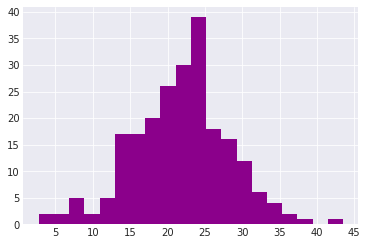

In [42]:
plt.hist(avg_songs_btw_hp_per_user.toPandas()['avg_songs_btw_hp_per_user'],bins=20,color='darkmagenta');

### Number of Different Artists Each User Listened To

In [43]:
num_distinct_artists = clean_user_log.groupby('UserId').agg(F.countDistinct("artist").alias('num_distinct_artists'))

In [44]:
num_distinct_artists.show(5)

+------+--------------------+
|UserId|num_distinct_artists|
+------+--------------------+
|100010|                 252|
|200002|                 339|
|   125|                   8|
|    51|                1385|
|   124|                2232|
+------+--------------------+
only showing top 5 rows



### Number of Songs Listened By Each User

In [45]:
num_songs_per_user = clean_user_log.groupby('userId').agg(F.count("song").alias("num_songs_per_user"))
num_songs_per_user.describe().show()

+-------+------------------+------------------+
|summary|            userId|num_songs_per_user|
+-------+------------------+------------------+
|  count|               225|               225|
|   mean|65391.013333333336|1013.8133333333334|
| stddev|105396.47791907164|1104.9607785540886|
|    min|                10|                 3|
|    max|                99|              8002|
+-------+------------------+------------------+



In [46]:
modeling_df = avg_songs_btw_hp_per_user.join(num_distinct_artists,'userId')
modeling_df = modeling_df.join(num_songs_per_user,'userId')
modeling_df = modeling_df.join(how_long_a_user,'userId')
modeling_df = modeling_df.join(paid_users,'userId')
modeling_df = modeling_df.join(user_gender,'userId')
modeling_df = modeling_df.join(user_total_song_length,'userId')
modeling_df = modeling_df.join(avg_num_songs_per_session,'userId')
modeling_df = modeling_df.join(churned_users,'userId')
modeling_df.show(5)

+------+-------------------------+--------------------+------------------+---------------+-------------+------------+----------------------+-------------------------+------------+
|userID|avg_songs_btw_hp_per_user|num_distinct_artists|num_songs_per_user|how_long_a_user|was_paid_user|gender_dummy|user_total_song_length|avg_num_songs_per_session|churned_user|
+------+-------------------------+--------------------+------------------+---------------+-------------+------------+----------------------+-------------------------+------------+
|100010|       22.916666666666668|                 252|               275|             65|            0|           1|     66940.89735000003|       39.285714285714285|           0|
|200002|                    19.35|                 339|               387|             86|            1|           0|     94008.87593999993|                     64.5|           0|
|   125|                      8.0|                   8|                 8|            122|          

### To summarize all the routine in one unique cell

In [47]:
spark = SparkSession \
    .builder \
    .appName('Sparkify') \
    .getOrCreate()

def extract_data():
    """
    Extracts the raw data necessary for modeling Churn.
    
    Output:
        raw_df: a raw dataframe
    """
    EVENT_DATA = 'mini_sparkify_event_data.json'

    df = spark.read.json(EVENT_DATA)
    
    return df

def transform_data(raw_df):
    """
    Make all the necessary transformations in the raw data and performs
    all the steps of the feature engineering process.
    
    Arguments:
        raw_df: the raw dataframe
    
    Output:
        modeling_df: the transformed dataframe
    """
    
    #Remove NaN Values
    df_clean = raw_df.dropna(how = "any", subset = ["userId", "sessionId"])
    
    #Remove Duplicated Values
    df_clean = df_clean.dropDuplicates()
    
    #Remove Empty Values
    df_clean = df_clean.filter(df_clean.userId != "")
    
    #Adjust Timestamp to Datetime
    get_strftime = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d %H:%M:%S"))
    df_clean = df_clean.withColumn("time_stamp", get_strftime(col("ts")))
    df_clean = df_clean.withColumn("registration_date", get_strftime(col("registration")))
    
    ###Feature Engineering
    
    ##Target (Churn)
    churn_fcn = udf(lambda x: 1 if x=='Cancellation Confirmation' else 0)
    churned_users = df_clean.withColumn("churn", churn_fcn(col("page")))\
                            .groupby('userId')\
                            .agg(F.max('churn').alias('churned_user'))
    
    ##Features
    #Number of Songs Each User Listen to on Average Between Visiting the HomePage
    function = udf(lambda ishome : int(ishome == 'Home'), IntegerType())
    user_window = Window \
        .partitionBy('userID') \
        .orderBy(F.desc('ts')) \
        .rangeBetween(Window.unboundedPreceding, 0)

    cusum = df_clean.filter((df_clean.page == 'NextSong') | (df_clean.page == 'Home')) \
        .select('userID', 'page', 'ts') \
        .withColumn('homevisit', function(col('page'))) \
        .withColumn('period', F.sum('homevisit').over(user_window))


    num_songs_per_period = cusum.filter((cusum.page == 'NextSong')) \
                          .groupBy('userID', 'period') \
                          .agg({'period':'count'})

    avg_songs_btw_hp_per_user = num_songs_per_period.groupby('userID') \
                                .agg(F.avg('count(period)') \
                                .alias('avg_songs_btw_hp_per_user'))
    
    #Number of Different Artists Each User Listened To
    num_distinct_artists = df_clean.groupby('UserId') \
                           .agg(F.countDistinct("artist") \
                           .alias('num_distinct_artists'))
    
    #Number of Songs Listened By Each User
    num_songs_per_user = df_clean.groupby('userId') \
                         .agg(F.count("song") \
                         .alias("num_songs_per_user"))
    
    #How Long Ago a User Signed Up Compared to the Maximum Time Stamp
    max_time_stamp = df_clean.agg(F.max(col("time_stamp")))
    max_time_stamp = max_time_stamp.collect()[0][0]
    df_clean.createOrReplaceTempView("user_log_table")
    how_long_a_user = spark.sql('''SELECT userId,
                                          datediff('2018-12-01 00:01:06' , registration_date) as how_long_a_user
                                   FROM(SELECT userId,
                                               MIN(registration_date) as registration_date
                                        FROM user_log_table
                                        GROUP BY 1)
                                ''')
    
    #If The User was Ever a Paid User
    free_or_paid = udf(lambda x : 1 if x == 'paid' else 0, IntegerType())
    was_paid = udf(lambda x : 1 if x > 0 else 0, IntegerType())
    paid_users = df_clean.select('userID', 'level') \
                         .withColumn('free_or_paid', free_or_paid(col('level'))) \
                         .groupby('userID').agg(F.sum('free_or_paid')) \
                         .withColumn('was_paid_user', was_paid(col('sum(free_or_paid)'))).select(['userID','was_paid_user'])
    
    #The user Gender
    user_gender = spark.sql('''SELECT userId, CASE WHEN gender = 'F' THEN 1 ELSE 0 END as dummy_gender
                           FROM(SELECT distinct userId, gender
                                FROM user_log_table)
                            ''')
    
    #Overall Time a User Listened to a Song
    user_total_song_length = df_clean.groupby('userID').agg(F.sum(col('length')).alias('user_total_song_length'))
    
    #Average Number of Songs Listened Per Session by Each User
    avg_num_songs_per_session = df_clean.filter(df_clean['page']=="NextSong") \
                                    .groupby(['userId','sessionId']).count() \
                                    .groupby('userId').agg(F.avg('count') \
                                    .alias('avg_num_songs_per_session'))
    
    ##Creating Modeling dataframe
    modeling_df = avg_songs_btw_hp_per_user.join(num_distinct_artists,'userId')
    modeling_df = modeling_df.join(num_songs_per_user,'userId')
    modeling_df = modeling_df.join(how_long_a_user,'userId')
    modeling_df = modeling_df.join(paid_users,'userId')
    modeling_df = modeling_df.join(user_gender,'userId')
    modeling_df = modeling_df.join(user_total_song_length,'userId')
    modeling_df = modeling_df.join(avg_num_songs_per_session,'userId')
    modeling_df = modeling_df.join(churned_users,'userId')
    
    modeling_df = modeling_df.drop('userId')
    
    return modeling_df

def load_data(modeling_df, outpath):
    """
    Save the transformed modeling data into a .csv file.
    
    Arguments:
        modeling_df: the modeling dataframe
        outpath: the output path with the file name
    """
    modeling_df.toPandas().to_csv(outpath)

def perform_etl_process(outpath):
    """
    Performs the full ETL process necessary for predicting
    churn. The final modeling dataframe will be returned and 
    also saved in a .csv file.
    
    Arguments:
        outpath: the output path with the file name
    
    Output:
        modeling_df: the modeling dataframe 
    """
    #Extract
    raw_df = extract_data()
    
    #Transform
    modeling_df = transform_data(raw_df)
    
    #Load
    load_data(modeling_df,'modeling_df.csv')
    
    return modeling_df


modeling_df = perform_etl_process('modeling_df.csv')

In [48]:
modeling_df.printSchema()

root
 |-- avg_songs_btw_hp_per_user: double (nullable = true)
 |-- num_distinct_artists: long (nullable = false)
 |-- num_songs_per_user: long (nullable = false)
 |-- how_long_a_user: integer (nullable = true)
 |-- was_paid_user: integer (nullable = true)
 |-- dummy_gender: integer (nullable = false)
 |-- user_total_song_length: double (nullable = true)
 |-- avg_num_songs_per_session: double (nullable = true)
 |-- churned_user: string (nullable = true)



# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [49]:
rest, validation = modeling_df.randomSplit([0.9, 0.1], seed=42)

assembler = VectorAssembler(inputCols=modeling_df.columns[:-1],
                            outputCol="transformeFeatures")
scaler = StandardScaler(inputCol="transformeFeatures",
                        outputCol="features")
indexer = StringIndexer(inputCol="churned_user", outputCol="label")

In [50]:
logistic_regressor = LogisticRegression(maxIter=10, regParam=0.0, elasticNetParam=0)

logistic_regressor_pipeline = Pipeline(stages=[assembler, scaler, indexer, logistic_regressor])
logistic_regressor_paramGrid = ParamGridBuilder() \
                              .addGrid(logistic_regressor.regParam,[0.0, 0.1]) \
                              .build()

logistic_regressor_crossval = CrossValidator(estimator=logistic_regressor_pipeline,
                                             estimatorParamMaps=logistic_regressor_paramGrid,
                                             evaluator=MulticlassClassificationEvaluator(),
                                             numFolds=3)
logistic_regressor_clf = logistic_regressor_crossval.fit(rest)
logistic_regressor_clf.avgMetrics

[0.6668652395712447, 0.6668652395712447]

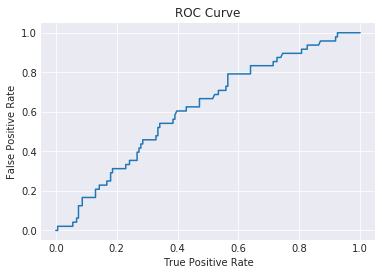

Area Under ROC Curve: 0.6147774327122147


In [51]:
trainingSummary = logistic_regressor_clf.bestModel.stages[3].summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Area Under ROC Curve: ' + str(trainingSummary.areaUnderROC))

In [52]:
evaluator = MulticlassClassificationEvaluator()
predictions = logistic_regressor_clf.transform(validation)
print("Accuracy: {}".format(evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})))
print("F1 Score:{}".format(evaluator.evaluate(predictions, {evaluator.metricName: "f1"})))

Accuracy: 0.75
F1 Score:0.6428571428571428


### RandomForest Cls

In [53]:
random_forest = RandomForestClassifier(numTrees=10, 
                                       impurity="gini")

random_forest_pipeline = Pipeline(stages=[assembler, scaler, indexer, random_forest])

random_forest_paramGrid = ParamGridBuilder() \
                          .addGrid(random_forest.maxDepth,[5, 20]) \
                          .build()

random_forest_crossval = CrossValidator(estimator=random_forest_pipeline,
                                        estimatorParamMaps=random_forest_paramGrid,
                                        evaluator=MulticlassClassificationEvaluator(),
                                        numFolds=3)

random_forest_clf = random_forest_crossval.fit(rest)

random_forest_clf.avgMetrics


evaluator = MulticlassClassificationEvaluator()
predictions = random_forest_clf.transform(validation)
print("Accuracy: {}".format(evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})))
print("F1 Score:{}".format(evaluator.evaluate(predictions, {evaluator.metricName: "f1"})))

Accuracy: 0.75
F1 Score:0.6428571428571428


### Conclusions
The first interesting conclusion is that following the directions of a typical CRISP-DM approach allowed an organized and well structered project. I first started the project with some business questions in mind: can we predict churn? What usefull information do I have available that could be usefull in this task? Then, an Explanatory Data Analysis guided the project into usefull insights that was essential for feature engineering.
The process of creating features was then guided by a ETL process, where data was first extracted from a json file and then all the necessary transformations were applied. The ETL process was summarized into a function and the resulting modeling database was loaded into a csv file.
Machine learning techniques were applied in order to predict churn and satisfactory results were obtained.
As a important conclusion, one should notice that more precise results could easily been obtained through a more intense search for parameters in the used models. However, that would require lot more computational power, which also means costs!¶

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.